# Day 21 pt2

Different approach, which makes a bit more sense with pictures.

In [15]:
import math
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from collections import deque

# Classes

In [16]:
class GardenMap:

    def __init__(self, raw_input):

        lines = raw_input.split("\n")
        lines = np.array([list(line) for line in lines])
        self.nrows, self.ncols = len(lines), len(lines[0])
        self.start = ((self.nrows-1)//2, (self.ncols-1)//2)
        self.plots = self.parse_input(raw_input)

    def parse_input(self, raw_input):
        lines = raw_input.split("\n")
        lines = np.array([list(line) for line in lines])
        nrows, ncols = len(lines), len(lines[0])

        garden_plots = np.ones((nrows, ncols), dtype=np.int8)
        garden_plots[lines == "."] = 0
        garden_plots[lines == "S"] = 0

        return garden_plots


In [17]:
class TiledGardenMap(GardenMap):

    def __init__(self, raw_input, N):

        super().__init__(raw_input)

        self.plots = np.tile(self.plots, (N, N))
        self.nrows, self.ncols = self.plots.shape
        self.start = ((self.nrows-1)//2, (self.ncols-1)//2)


# Functions

In [18]:
def bfs_distance(grid, start):
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    rows, cols = len(grid), len(grid[0])

    distances = [[-1 for _ in range(cols)] for _ in range(rows)]
    
    # row, column, distance
    queue = deque([(start[0], start[1], 0)])
    
    while queue:
        r, c, dist = queue.popleft()

        # skip rocks, already visited or out of bounds
        if r < 0 or r >= rows or c < 0 or c >= cols or grid[r][c] == 1 or distances[r][c] != -1:
            continue
        
        distances[r][c] = dist
        
        for dr, dc in directions:
            queue.append((r + dr, c + dc, dist + 1))

    return np.array(distances)

In [19]:
def manhattan_distance(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

# Get the data

The test data isn't very useful in this case, so we'll ignore it.

In [20]:
with open("../inputs/day21.txt") as f:
    input_raw = f.read()

# Exploit the recurring diamond pattern

There's a diamond pattern when the original data is tiled, and it would be nice to use that, instead of the polynomial approach.

In [21]:
# create a tiled version of the original garden, to get a sense of what the infinite version would be like
N = 3
tiled_garden = TiledGardenMap(input_raw, N=N)
distances = bfs_distance(tiled_garden.plots, tiled_garden.start)

target_steps = (tiled_garden.nrows - 1) // 2

reachable = (
    (distances >= 0) & \
    (distances <= target_steps) & \
    ((distances % 2) == (target_steps % 2))
)

reachable.sum()

34009

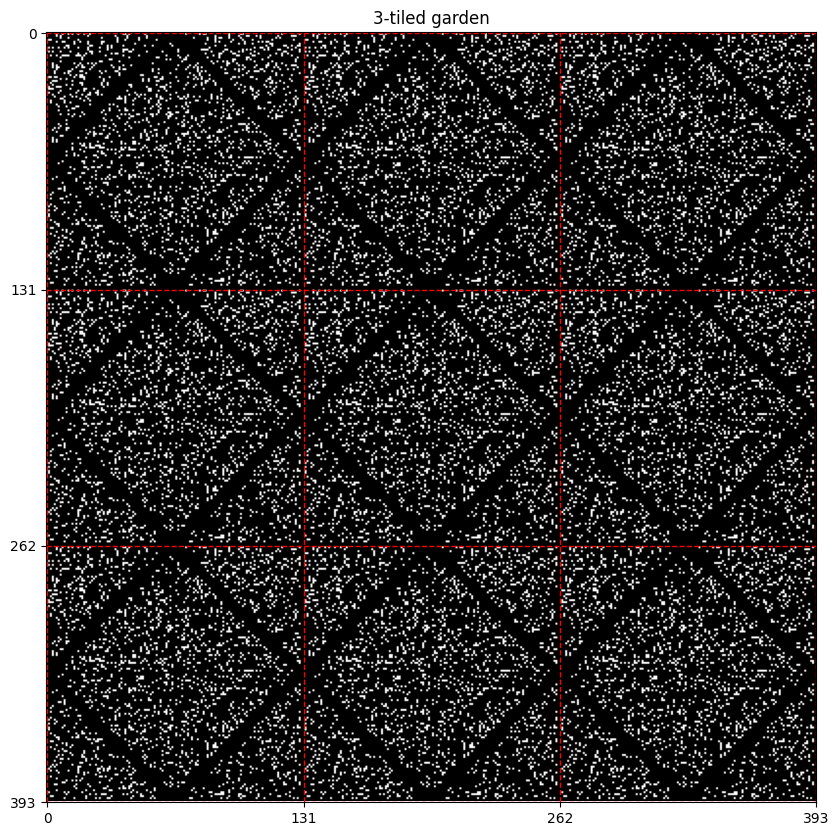

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(tiled_garden.plots, cmap='gray')
plt.title('3-tiled garden')

# show the tiling
plt.xticks(range(0, tiled_garden.nrows+1, 131))
plt.yticks(range(0, tiled_garden.ncols+1, 131))
plt.grid(which='both', color='red', linestyle='dashed', linewidth=1)

In [23]:
# these are the midpoints of the inner 9 diamonds
midpoint = (tiled_garden.start[0], tiled_garden.start[1])
diamond_midpoints = {
    "central":     midpoint,
    "north":      (midpoint[0]-131,  midpoint[1]),
    "northwest":  (midpoint[1]-65.5, midpoint[1]-65.5),
    "west":       (midpoint[0],      midpoint[1]-131),
    "southwest":  (midpoint[0]+65.5, midpoint[1]-65.5),
    "south":      (midpoint[0]+131,  midpoint[1]),
    "southeast":  (midpoint[0]+65.5, midpoint[1]+65.5),
    "east":       (midpoint[0],      midpoint[1] + 131),
    "northeast":  (midpoint[0]-65.5, midpoint[1]+65.5)
}

In [24]:
diamond_midpoints

{'central': (196, 196),
 'north': (65, 196),
 'northwest': (130.5, 130.5),
 'west': (196, 65),
 'southwest': (261.5, 130.5),
 'south': (327, 196),
 'southeast': (261.5, 261.5),
 'east': (196, 327),
 'northeast': (130.5, 261.5)}

In [25]:
# create a mask for each diamond so we can pick out the reachable plots in each one
max_dist = 65
diamond_masks = {}
for diamond, midpoint in diamond_midpoints.items():

    coords = [(row,col) 
              for row in range(tiled_garden.ncols) for col in range(tiled_garden.ncols) 
              if manhattan_distance((row,col), midpoint) <= max_dist]

    row_indices, col_indices = zip(*coords)

    mask = np.zeros_like(tiled_garden.plots, dtype=int)
    mask[row_indices, col_indices] += 1

    diamond_masks[diamond] = mask
    

In [26]:
# There are 9 diamonds in the 3-tiled garden, but only 4 different counts: 
#  two rock arrangements * two different parity versions (since the tiles have odd dimensions)
reachable_in_diamond = {}
for diamond, mask in diamond_masks.items():
    reachable_in_diamond[diamond] = np.sum(reachable & mask)

reachable_in_diamond

{'central': 3717,
 'north': 3797,
 'northwest': 3766,
 'west': 3797,
 'southwest': 3786,
 'south': 3797,
 'southeast': 3766,
 'east': 3797,
 'northeast': 3786}

# Check against results for various N-tiled gardens

We'll just pick one of the diamonds for each count, e.g. 'north' just means 'a diamond with the same count as the north diamond'.

In [27]:
N = 3

a = math.ceil(N/2)
b = N-a

result = a * (a * reachable_in_diamond['north'] + b * reachable_in_diamond['northwest'] ) + \
         b * (a * reachable_in_diamond['southwest'] + b * reachable_in_diamond['central'] ) 

assert result == 34009

In [28]:
N = 5

a = math.ceil(N/2)
b = N - a

result = a * (a * reachable_in_diamond['north'] + b * reachable_in_diamond['northwest'] ) + \
         b * (a * reachable_in_diamond['southwest'] + b * reachable_in_diamond['central'] ) 

assert result == 94353

In [29]:
N = 7

a = math.ceil(N/2)
b = N - a

result = a * (a * reachable_in_diamond['north'] + b * reachable_in_diamond['northwest'] ) + \
         b * (a * reachable_in_diamond['southwest'] + b * reachable_in_diamond['central'] ) 

assert result == 184829 

In [36]:
N = 13

a = math.ceil(N/2)
b = N - a

result = a * (a * reachable_in_diamond['north'] + b * reachable_in_diamond['northwest'] ) + \
         b * (a * reachable_in_diamond['southwest'] + b * reachable_in_diamond['central'] ) 

result

637049

# Result 

In [31]:
target_steps = 26501365
N = 1 + (2 * target_steps) // 131

a = math.ceil(N/2)
b = N - a

result = a * (a * reachable_in_diamond['north'] + b * reachable_in_diamond['northwest'] ) + \
         b * (a * reachable_in_diamond['southwest'] + b * reachable_in_diamond['central'] ) 

# 616583483179597
print(f"Part 2: {result}") 

Part 2: 616583483179597
